In [1]:
# Data collection
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

# Define the pairs
stock1 = 'F'   # Ford
stock2 = 'GM'  # General Motors

# Fetch historical data
def get_data(stock, start, end):
    data = yf.download(stock, start=start, end=end)
    return data['Adj Close']

start_date = '2015-01-01'
end_date = '2023-01-01'

f_data = get_data(stock1, start_date, end_date)
gm_data = get_data(stock2, start_date, end_date)

# Combine into a single DataFrame
df = pd.DataFrame({stock1: f_data, stock2: gm_data}).dropna()

[*********************100%%**********************]  1 of 1 completed

/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/Caskroom/miniforge/base/envs/py312/lib/python3.12/site-packages/yfinance/utils.py:782: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



[*********************100%%**********************]  1 of 1 completed


In [2]:
# Pair selection
# Perform cointegration test
coint_result = coint(df[stock1], df[stock2])
p_value = coint_result[1]
print(f'Cointegration p-value: {p_value}')

if p_value < 0.05:
    print("The pair is cointegrated. Suitable for pairs trading.")
else:
    print("The pair is not cointegrated. Choose different stocks.")

Cointegration p-value: 0.6053291855203327
The pair is not cointegrated. Choose different stocks.


In [3]:
# Spread calculation
# Calculate the spread
df['spread'] = df[stock1] - df[stock2]

# Calculate moving average and standard deviation
window = 30
df['spread_mean'] = df['spread'].rolling(window=window).mean()
df['spread_std'] = df['spread'].rolling(window=window).std()

# Calculate z-score
df['z_score'] = (df['spread'] - df['spread_mean']) / df['spread_std']

# Drop rows with NaN values
df = df.dropna()

In [6]:
# Signal generation
# Define thresholds
entry_threshold = 1.0
exit_threshold = 0.5

# Generate signals
df['long'] = (df['z_score'] < -entry_threshold).astype(int)
df['short'] = (df['z_score'] > entry_threshold).astype(int)
df['exit'] = (abs(df['z_score']) < exit_threshold).astype(int)

# Position management
position = 0
positions = []

for i in range(len(df)):
    if df['long'].iloc[i] and position == 0:
        position = 1
    elif df['short'].iloc[i] and position == 0:
        position = -1
    elif df['exit'].iloc[i] and position != 0:
        position = 0
    positions.append(position)

df['position'] = positions

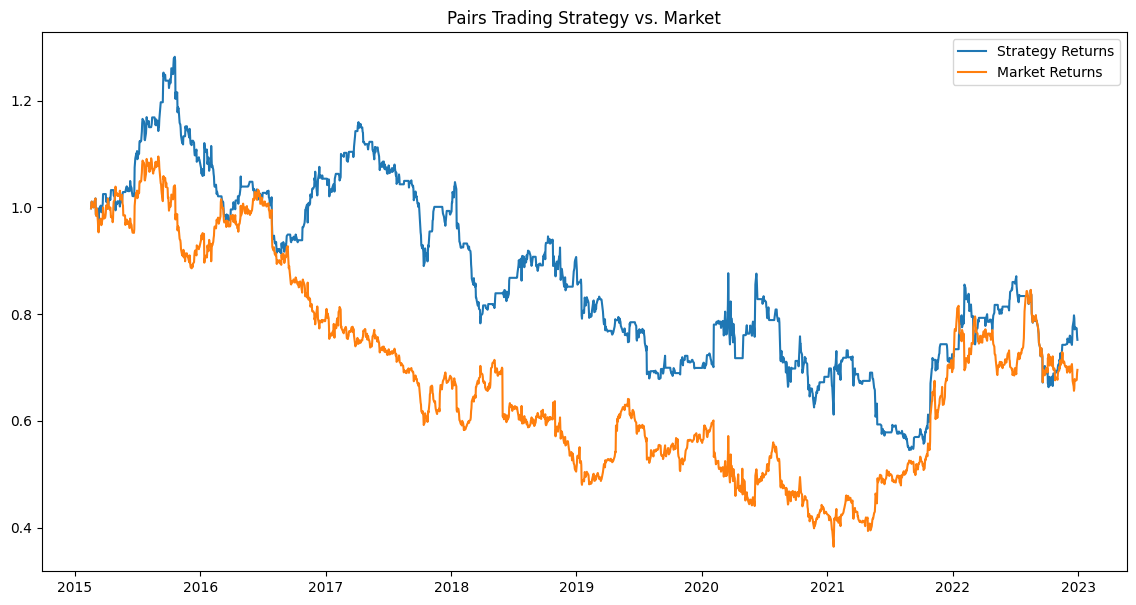

Total Return: -24.81%
Annual Return: -1.50%
Annual Volatility: 20.58%
Sharpe Ratio: -0.07


/var/folders/_n/nybmwjg90rxfzcynss3bqkr80000gp/T/ipykernel_16537/1219252389.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_return = df['cumulative_strategy'][-1] - 1


In [7]:
# Backtesting
# Calculate returns
df['return_f'] = df[stock1].pct_change()
df['return_gm'] = df[stock2].pct_change()

# Strategy returns
df['strategy_return'] = df['position'].shift(1) * (df['return_f'] - df['return_gm'])

# Cumulative returns
df['cumulative_strategy'] = (1 + df['strategy_return']).cumprod()
df['cumulative_market'] = (1 + (df['return_f'] - df['return_gm'])).cumprod()

# Plot the results
plt.figure(figsize=(14,7))
plt.plot(df['cumulative_strategy'], label='Strategy Returns')
plt.plot(df['cumulative_market'], label='Market Returns')
plt.legend()
plt.title('Pairs Trading Strategy vs. Market')
plt.show()

# Performance metrics
total_return = df['cumulative_strategy'][-1] - 1
annual_return = df['strategy_return'].mean() * 252
annual_vol = df['strategy_return'].std() * np.sqrt(252)
sharpe_ratio = annual_return / annual_vol

print(f'Total Return: {total_return:.2%}')
print(f'Annual Return: {annual_return:.2%}')
print(f'Annual Volatility: {annual_vol:.2%}')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')